 ## 1. Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import Normalize
from sklearn.metrics import confusion_matrix

## 2. Type of dataset

In [2]:
type(fashion_mnist) # fashion_mnist is a module inside tensorflow.keras.datasets

module

In [86]:
!pip install nbformat

## 3. Load Fashion-MNIST dataset

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### 3.1 Max Value in the entire X_train dataset

In [7]:
np.max(X_train)

255

### 3.2 Avg Value in the entire X_train Dataset

In [8]:
np.mean(X_train)

72.94035223214286

### 3.3 Labels (class names or categories) corresponding to the training dataset X_train

In [9]:
y_train # contains numbers (0–9), each representing a clothing category. Stores the class labels for the images in X_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [10]:
np.unique(y_train) # returns the sorted unique class labels present in y_train

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
class_names = [
    "t-shirt/top", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]




## 4. Data Exploration|

### 4.1 Dimensions of the training dataset 

In [12]:
X_train.shape 


(60000, 28, 28)

### 4.2 Dimensions of the testing dataset 

In [13]:
X_test.shape


(10000, 28, 28)

### 4.3 Visualizing a sample image from the X_train dataset 

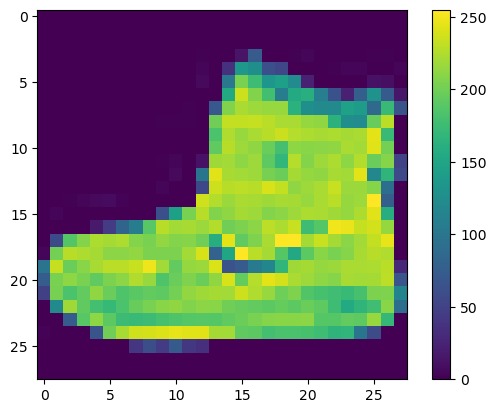

In [14]:
plt.figure() # Creates a new figure in Matplotlib
plt.imshow(X_train[0]) # Displays the second image from X_train. #cmap='gray'
plt.colorbar() # Adds a color scale next to the image.

### 4.4 Normalize the image pixel values from [0, 255] to [0, 1]

In [15]:
 X_train = X_train/255.0

In [16]:
 X_test = X_test/255.0

In [17]:
np.max(X_train)

1.0

### 4.5 Display a sample image to see results after normalization

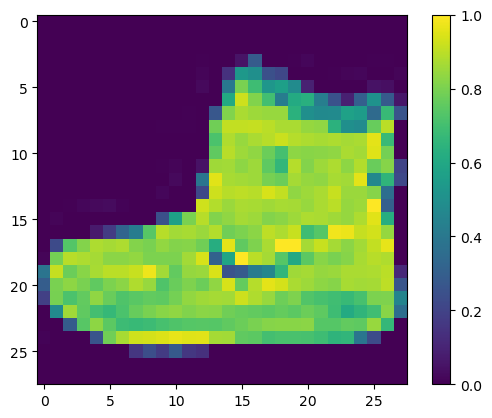

In [18]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()

## 5 Data Augmentation

### 5.1 Reshaping 

In [19]:
X_train = X_train.reshape(-1, 28, 28, 1)

### 5.2 Random selection

In [20]:
random_indices = random.sample(range(X_train.shape[0]), 5)
random_images = X_train[random_indices]

### 5.3 Augmentation techniques

In [21]:
augmentations = {
    "Rotated (30°)": ImageDataGenerator(rotation_range=30), #Randomly rotates the image up to 30 degrees.
    "Zoomed (20%)": ImageDataGenerator(zoom_range=0.2),  #Randomly zooms in or out by 20%.
    "Width Shifted (20%)": ImageDataGenerator(width_shift_range=0.2), # Moves the image left or right by 20% of its width.
    "Height Shifted (20%)": ImageDataGenerator(height_shift_range=0.2), # Moves the image up or down by 20% of its height.
    "Sheared (15°)": ImageDataGenerator(shear_range=15), #  Slants the image by 15 degrees (like tilting a page).
}

### 5.4 Visualizing each Aug Techn.

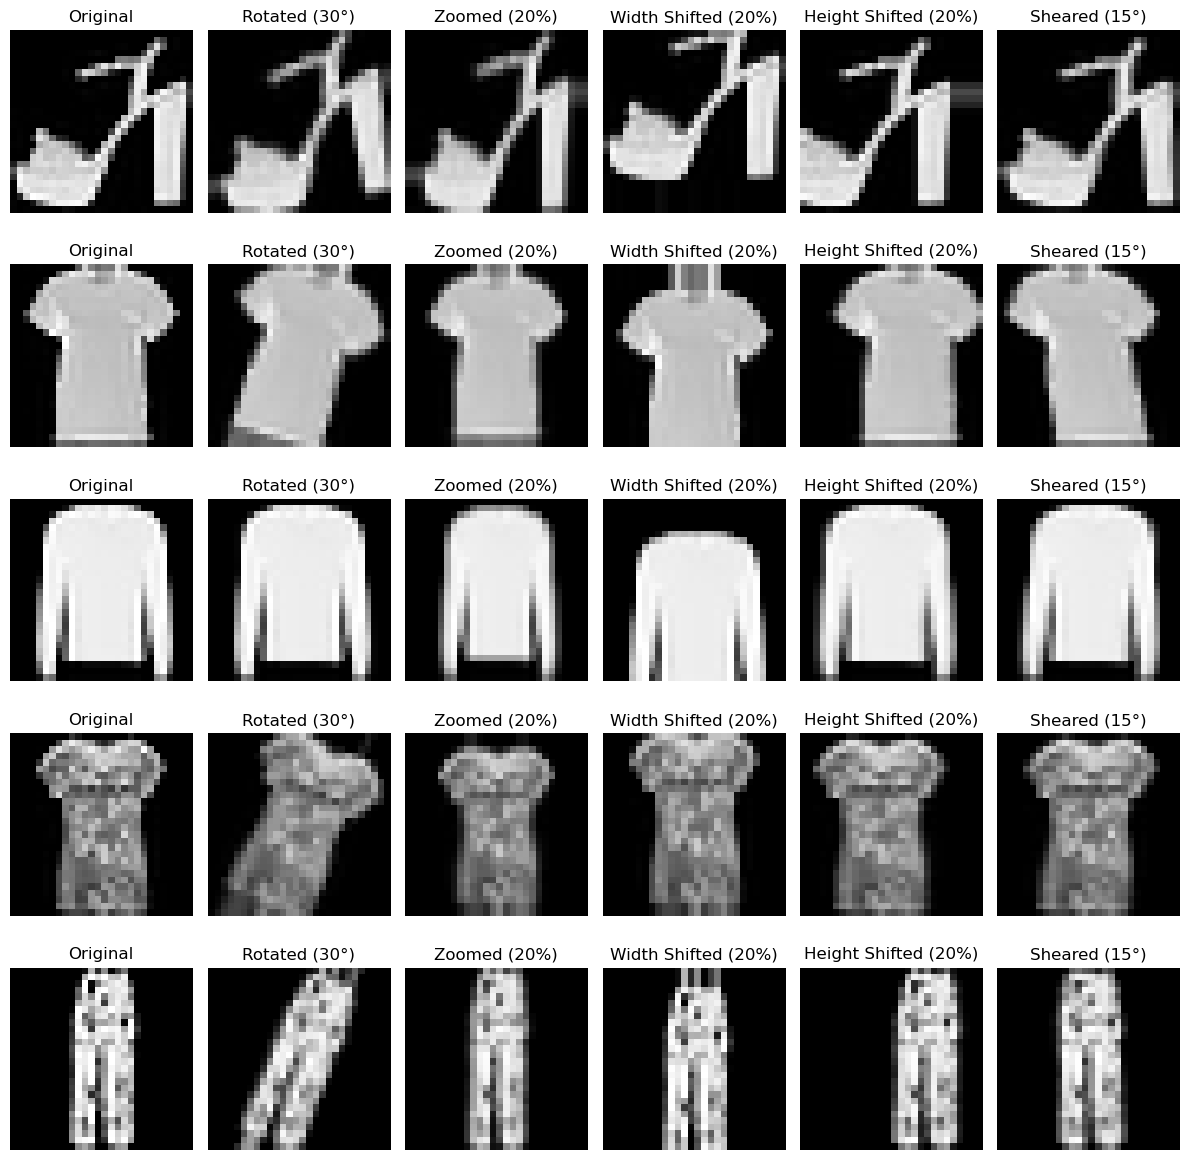

In [22]:

fig, axes = plt.subplots(len(random_images), len(augmentations) + 1, figsize=(12, 12))

colormap = 'gray'

norm = Normalize(vmin=0, vmax=1)

for i, image in enumerate(random_images):
    image_2d = image.squeeze()
    
    axes[i, 0].imshow(image_2d, cmap=colormap, norm=norm)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    for j, (title, generator) in enumerate(augmentations.items()):
        if len(image.shape) == 2:
            image_for_aug = np.expand_dims(np.expand_dims(image, axis=0), axis=-1)
        elif len(image.shape) == 3 and image.shape[-1] == 1:
            image_for_aug = np.expand_dims(image, axis=0)
        else:
            image_for_aug = np.expand_dims(image, axis=0)
            
        augmented_image = next(generator.flow(image_for_aug, batch_size=1))[0]
        
        augmented_image_2d = augmented_image.squeeze()
        
        axes[i, j + 1].imshow(augmented_image_2d, cmap=colormap, norm=norm)
        axes[i, j + 1].set_title(title)
        axes[i, j + 1].axis("off")

plt.tight_layout()
plt.show()

## 6. Training Models

### 6.1 Model Training on Original Data  without Augmentation

In [23]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

y_train_categorical = to_categorical(y_train, num_classes=10)
y_test_categorical = to_categorical(y_test, num_classes=10)

def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        BatchNormalization(), # adjusting values so that they have similar ranges

        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(), # noramlize again to keep the values stable
        
        MaxPooling2D(2,2), # reduce the image size again to focus on most useful features
        Flatten(), # convert filtered image into 1d, prepare for classification
        Dense(128, activation='relu'),
        Dropout(0.5), # prevent overfitting - memorizing training data too much
        Dense(10, activation='softmax') # Final Outup layer - 10 neurons for 10 categories in fashion MNIST. Softmax gives a probability for each category
    ])
    return model # so that it can be used

model_before = create_model() # Calls the function to create a new model.

model_before.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_before.summary() # Displays a summary of all layers, filters, and parameters.




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,418 (880.54 KB)

 Trainable params: 225,226 (879.79 KB)

 Non-trainable params: 192 (768.00 B)

In [63]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_before = model_before.fit(
    X_train, y_train_categorical, 
    epochs=20, batch_size=64,
    validation_data=(X_test, y_test_categorical), 
)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9589 - loss: 0.1079 - val_accuracy: 0.9140 - val_loss: 0.3676
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9610 - loss: 0.1013 - val_accuracy: 0.9155 - val_loss: 0.3773
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.9614 - loss: 0.1006 - val_accuracy: 0.9143 - val_loss: 0.3181
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.9626 - loss: 0.0956 - val_accuracy: 0.9145 - val_loss: 0.3502
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.9636 - loss: 0.0957 - val_accuracy: 0.9126 - val_loss: 0.4071
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9676 - loss: 0.0847 - val_accuracy: 0.9150 - val_loss: 0.3492
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9662 - loss: 0.0878 - val_accuracy: 0.9157 - val_loss: 0.3463
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.9666 - loss: 0.0882 - 

### Saving original model (before aug)

In [79]:
model_before.save("model_before_augmentation.keras")

## 6.2  Model Training on Aug. Data 

In [65]:


X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
y_train_categorical = to_categorical(y_train, num_classes=10)
y_test_categorical = to_categorical(y_test, num_classes=10)

train_datagen = ImageDataGenerator(
    rotation_range=3,        
    zoom_range=0.05,         
    width_shift_range=0.02,  
    height_shift_range=0.02, 
    horizontal_flip=False    
)

augment_size = X_train.shape[0]
X_aug = X_train.copy()
y_aug = y_train_categorical.copy()

X_augmented = next(train_datagen.flow(X_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False))[0]

X_train_combined = np.concatenate((X_train, X_augmented))
y_train_combined = np.concatenate((y_train_categorical, y_aug))

print("Original training set:", X_train.shape)
print("Augmented training set:", X_augmented.shape)
print("Combined training set:", X_train_combined.shape)

def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

model_after = create_model()
model_after.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_after = model_after.fit(
    X_train_combined, y_train_combined,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test_categorical),
)

Original training set: (60000, 28, 28, 1)
Augmented training set: (60000, 28, 28, 1)
Combined training set: (120000, 28, 28, 1)
Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - accuracy: 0.7892 - loss: 0.6074 - val_accuracy: 0.8885 - val_loss: 0.3053
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.8782 - loss: 0.3363 - val_accuracy: 0.8856 - val_loss: 0.3063
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.8943 - loss: 0.2876 - val_accuracy: 0.8983 - val_loss: 0.2830
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9010 - loss: 0.2654 - val_accuracy: 0.8992 - val_loss: 0.2736
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - accuracy: 0.9117 - loss: 0.2394 - val_accuracy: 0.9092 - val_loss: 0.2541
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.9174 - loss: 0.2203 - val_accuracy: 0.9057 - val_loss: 0.2842
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9236 - los

### Saving Model after augmentation

In [80]:
model_after.save("model_after_augmentation.keras")

## 7. Model performance Before and After Aug

In [81]:

model_before = load_model("model_before_augmentation.keras", compile=False)
model_after = load_model("model_after_augmentation.keras", compile=False)

In [82]:
model_before.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_after.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
import numpy as np

print("\n==== Model Performance BEFORE Augmentation ====")
test_loss_before, test_accuracy_before = model_before.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy_before:.4f}")
print(f"Test Loss: {test_loss_before:.4f}")

y_pred_before = model_before.predict(X_test)
y_pred_classes_before = np.argmax(y_pred_before, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

print("\n==== Model Performance AFTER Augmentation ====")
test_loss_after, test_accuracy_after = model_after.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy_after:.4f}")
print(f"Test Loss: {test_loss_after:.4f}")

y_pred_after = model_after.predict(X_test)
y_pred_classes_after = np.argmax(y_pred_after, axis=1)

print("\n========== SUMMARY COMPARISON ==========")
print(f"Test Accuracy BEFORE Augmentation: {test_accuracy_before:.4f}")
print(f"Test Accuracy AFTER  Augmentation: {test_accuracy_after:.4f}")
print(f"Difference in Accuracy: {test_accuracy_after - test_accuracy_before:+.4f}")

print(f"\nTest Loss BEFORE Augmentation: {test_loss_before:.4f}")
print(f"Test Loss AFTER  Augmentation: {test_loss_after:.4f}")
print(f"Difference in Loss: {test_loss_after - test_loss_before:+.4f}")


==== Model Performance BEFORE Augmentation ====
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9105 - loss: 0.4518
Test Accuracy: 0.9108
Test Loss: 0.4501
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

==== Model Performance AFTER Augmentation ====
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9188 - loss: 0.3256
Test Accuracy: 0.9203
Test Loss: 0.3018
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

========== SUMMARY COMPARISON ==========
Test Accuracy BEFORE Augmentation: 0.9108
Test Accuracy AFTER  Augmentation: 0.9203
Difference in Accuracy: +0.0095

Test Loss BEFORE Augmentation: 0.4501
Test Loss AFTER  Augmentation: 0.3018
Difference in Loss: -0.1483


## Confusion Matrix -BEFORE 

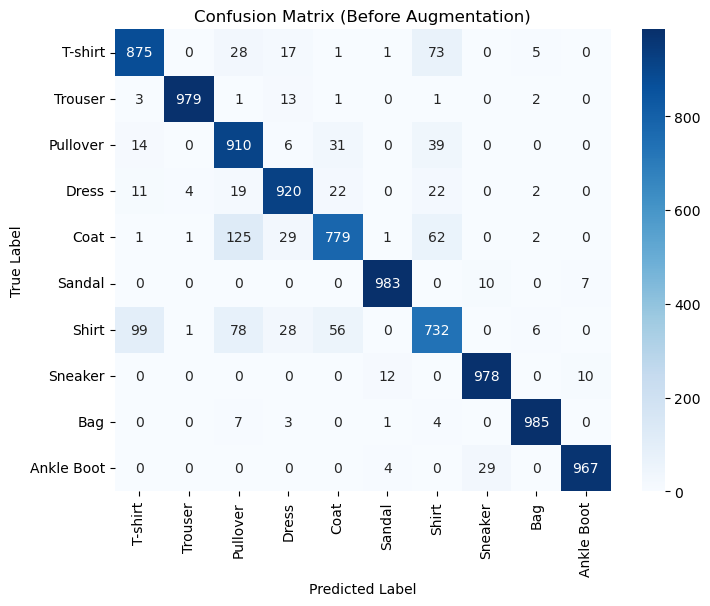

In [73]:



cm = confusion_matrix(y_true, y_pred_classes_before)

class_labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Before Augmentation)")
plt.show()

## Confusion Matrix -AFTER


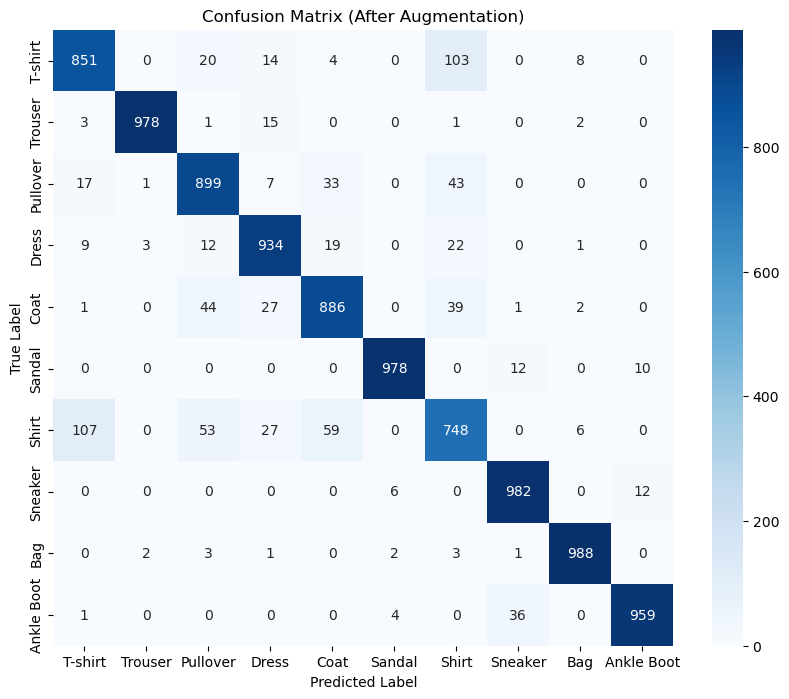

In [74]:
conf_matrix_after = confusion_matrix(y_true, y_pred_classes_after)

class_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_after, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (After Augmentation)")

plt.show()

### 7.1 Comparing the performance of the two models

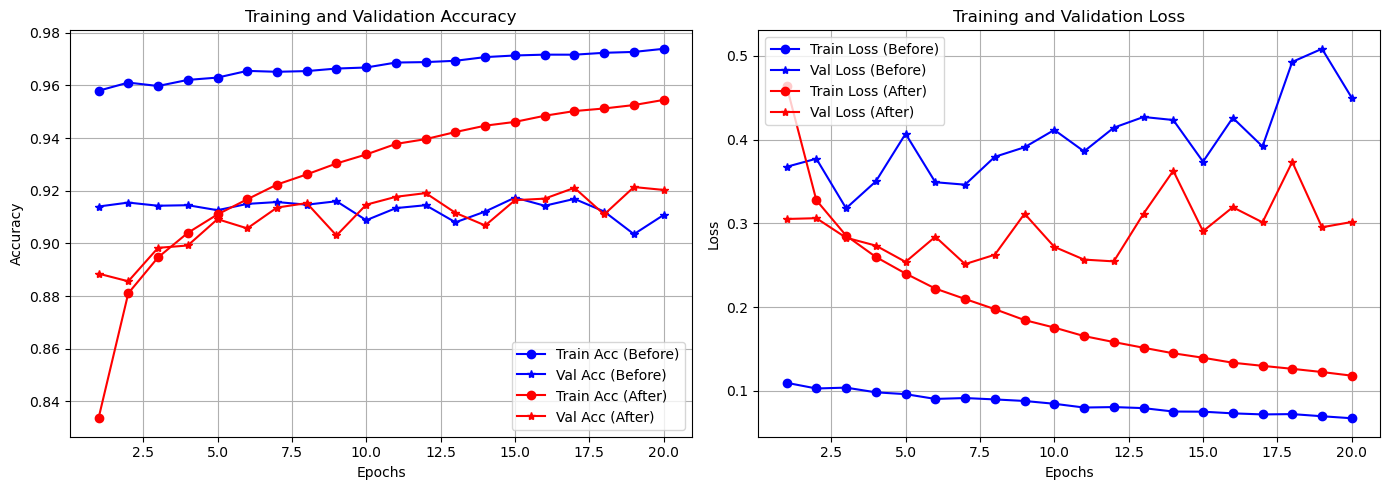

In [85]:

train_acc_before = history_before.history['accuracy']
val_acc_before = history_before.history['val_accuracy']
train_loss_before = history_before.history['loss']
val_loss_before = history_before.history['val_loss']

train_acc_after = history_after.history['accuracy']
val_acc_after = history_after.history['val_accuracy']
train_loss_after = history_after.history['loss']
val_loss_after = history_after.history['val_loss']

epochs_before = range(1, len(train_acc_before) + 1)
epochs_after = range(1, len(train_acc_after) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_before, train_acc_before, 'bo-', label='Train Acc (Before)')
plt.plot(epochs_before, val_acc_before, 'b*-', label='Val Acc (Before)')
plt.plot(epochs_after, train_acc_after, 'ro-', label='Train Acc (After)')
plt.plot(epochs_after, val_acc_after, 'r*-', label='Val Acc (After)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_before, train_loss_before, 'bo-', label='Train Loss (Before)')
plt.plot(epochs_before, val_loss_before, 'b*-', label='Val Loss (Before)')
plt.plot(epochs_after, train_loss_after, 'ro-', label='Train Loss (After)')
plt.plot(epochs_after, val_loss_after, 'r*-', label='Val Loss (After)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()